# **Proyecto de Minería de Datos: Clasificación de Zonas de Vivienda mediante Clustering**

### **Autor:**  
**Deyvis Quispe Mamani**

### **Curso:**  
**Minería de Datos**

### **Docente:**  
**Abel Ángel Sullón Macalupu**

---

### **Descripción del Proyecto**

En este proyecto se aplican técnicas de **aprendizaje no supervisado** (clustering) para realizar una **clasificación de zonas de vivienda** basándose en diversas características socioeconómicas y urbanas.  
El objetivo es identificar **grupos o patrones naturales** entre las zonas de una ciudad en función de variables como la distancia al centro, el precio promedio, el nivel de criminalidad, el entorno verde, el ruido, y los servicios disponibles.

El flujo de trabajo desarrollado incluye:

1. **Carga y exploración de datos.**  
2. **Selección de características relevantes** y **escalado** de variables con `StandardScaler`.  
3. **Determinación del número óptimo de clusters** mediante el *método del codo* y el *índice Silhouette*.  
4. **Aplicación de distintos algoritmos de clustering**, incluyendo:
   - `K-Means`
   - `Gaussian Mixture Model (GMM)`
   - `DBSCAN`
5. **Evaluación comparativa** de los modelos mediante métricas de cohesión y separación (Silhouette, Davies-Bouldin y Calinski-Harabasz).  
6. **Visualización 2D con PCA** para representar gráficamente los clusters.  
7. **Perfilado de clusters**, mostrando los valores medios, mínimos y máximos por variable.  
8. **Exportación de artefactos (`.joblib`)** y **funciones para predecir el cluster** de nuevos registros.

---

### **Estructura del Notebook**

El notebook conserva la estructura de los laboratorios previos, organizada en secciones numeradas, con bloques claros para cada fase del proceso de minería de datos y visualizaciones individuales para facilitar la interpretación de resultados.

---

### **Palabras clave**
`Minería de Datos`, `Clustering`, `KMeans`, `Gaussian Mixture`, `DBSCAN`, `Clasificación de Zonas`, `Python`, `Scikit-learn`

---


In [1]:
# =========================================
# 1) Cargar datos y exploración
# =========================================
import os, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

DATA_FILE = "/content/zonas_vivienda_data.csv"
assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"

df = pd.read_csv(DATA_FILE)
print("Dimensiones:", df.shape)
print("Columnas:", list(df.columns))
display(df.head())
display(df.describe(include="all"))


Dimensiones: (2000, 11)
Columnas: ['Lat', 'Lon', 'DistCentro_km', 'Area_m2', 'Habitaciones', 'Precio_USD', 'IndiceCrimen', 'IndiceVerde', 'IndiceRuido', 'PuntajeColegios', 'PuntajeTransporte']


,Lat,Lon,DistCentro_km,Area_m2,Habitaciones,Precio_USD,IndiceCrimen,IndiceVerde,IndiceRuido,PuntajeColegios,PuntajeTransporte
0,-12.142756,-77.095202,12.114,119.0,2,171476,85.3,30.0,80.9,52.6,66.2
1,-12.199037,-77.123723,19.085,98.5,3,141245,71.4,51.2,67.7,64.4,74.7
2,-12.211719,-77.088903,19.021,119.2,5,175394,80.4,38.7,75.6,69.8,65.6
3,-12.047812,-77.036031,0.751,95.7,2,276887,75.0,37.5,80.9,69.7,80.7
4,-12.164092,-77.144381,17.096,35.0,4,53051,67.0,43.9,79.4,42.5,55.3


,Lat,Lon,DistCentro_km,Area_m2,Habitaciones,Precio_USD,IndiceCrimen,IndiceVerde,IndiceRuido,PuntajeColegios,PuntajeTransporte
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,-12.101294,-77.104029,9.908099,85.304700,3.312000,181590.992000,61.695100,47.377600,66.647850,64.265450,79.33680
std,0.048459,0.047016,6.173314,28.457278,1.465172,83460.088246,17.395898,12.853719,12.285468,10.978195,11.25635
min,-12.248557,-77.242399,0.168000,35.000000,1.000000,41312.000000,21.300000,11.900000,36.000000,29.400000,45.60000
25%,-12.134292,-77.145317,4.006750,64.400000,2.000000,118815.000000,46.400000,37.675000,55.875000,57.000000,71.50000
50%,-12.097835,-77.102469,10.361500,84.950000,3.000000,167728.000000,60.700000,49.200000,66.800000,65.200000,80.60000
75%,-12.057559,-77.062100,14.213250,105.900000,5.000000,230847.750000,77.000000,57.000000,77.200000,72.100000,87.70000
max,-12.019701,-77.011398,26.597000,173.400000,6.000000,586548.000000,95.000000,76.600000,94.600000,96.800000,100.00000


In [2]:
# =========================================
# 2) Selección de características y escalado
# =========================================
from sklearn.preprocessing import StandardScaler

features = ["DistCentro_km","Area_m2","Habitaciones","Precio_USD",
            "IndiceCrimen","IndiceVerde","IndiceRuido",
            "PuntajeColegios","PuntajeTransporte"]

X = df[features].copy()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs.shape


(2000, 9)

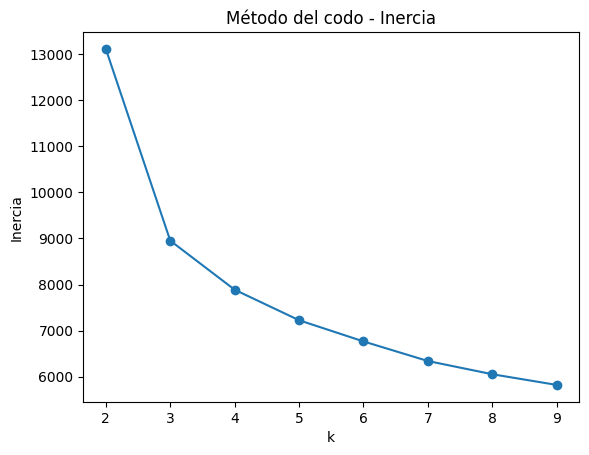

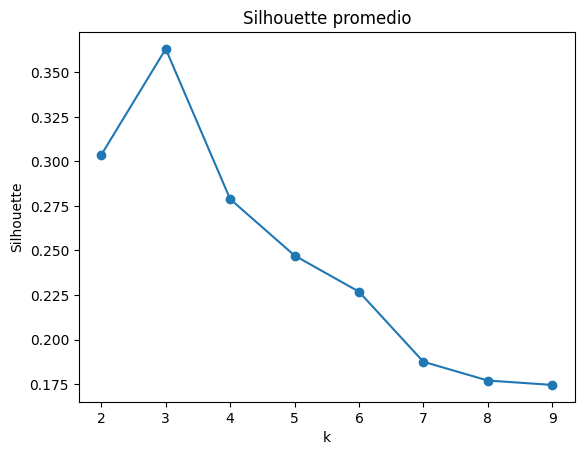

3

In [3]:
# =========================================
# 3) Codo y Silhouette para elegir K
# =========================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

k_values = list(range(2, 10))
inertia, silh = [], []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    inertia.append(km.inertia_)
    silh.append(silhouette_score(Xs, labels))

plt.figure()
plt.plot(k_values, inertia, marker="o")
plt.title("Método del codo - Inercia")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.show()

plt.figure()
plt.plot(k_values, silh, marker="o")
plt.title("Silhouette promedio")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

k_best = k_values[int(np.argmax(silh))]
k_best


In [4]:
# =========================================
# 4) Entrenar KMeans / GMM / DBSCAN y comparar métricas
# =========================================
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd

models = {}
models["kmeans"] = KMeans(n_clusters=int(k_best), n_init=10, random_state=42).fit(Xs)
models["gmm"] = GaussianMixture(n_components=int(k_best), covariance_type="full", random_state=42).fit(Xs)
models["dbscan"] = DBSCAN(eps=1.2, min_samples=10).fit(Xs)

def safe_scores(Xs, labels):
    unique = np.unique(labels)
    if len(unique) <= 1:
        return {"silhouette": np.nan, "davies": np.nan, "calinski": np.nan}
    return {
        "silhouette": silhouette_score(Xs, labels),
        "davies": davies_bouldin_score(Xs, labels),
        "calinski": calinski_harabasz_score(Xs, labels)
    }

rows = []
for name, mdl in models.items():
    labels = mdl.labels_ if hasattr(mdl, "labels_") else mdl.predict(Xs)
    s = safe_scores(Xs, labels)
    rows.append({"modelo": name, **s})

res = pd.DataFrame(rows).sort_values(by=["silhouette","calinski"], ascending=[False, False])
display(res)


,modelo,silhouette,davies,calinski
0,kmeans,0.363169,1.119177,1009.138075
1,gmm,0.363053,1.117304,1006.417065
2,dbscan,0.031485,2.078253,219.206681


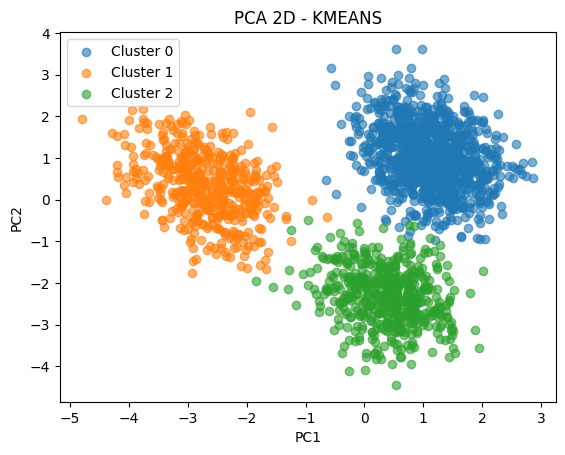

In [5]:
# =========================================
# 5) Visualización con PCA (2D)
# =========================================
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

best_model_name = res.iloc[0]["modelo"]
best_model = models[best_model_name]
labels_best = best_model.labels_ if hasattr(best_model, "labels_") else best_model.predict(Xs)

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xs)

plt.figure()
for lab in np.unique(labels_best):
    mask = labels_best == lab
    plt.scatter(Xp[mask,0], Xp[mask,1], alpha=0.6, label=f"Cluster {lab}")
plt.title(f"PCA 2D - {best_model_name.upper()}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


In [6]:
# =========================================
# 6) Perfilado de clusters
# =========================================
labels_best = best_model.labels_ if hasattr(best_model, "labels_") else best_model.predict(Xs)

df_profile = pd.DataFrame(X, copy=True)
df_profile["cluster"] = labels_best
profile = df_profile.groupby("cluster").agg(["mean","median","min","max"])
profile


DistCentro_km                           Area_m2                      \
                 mean  median    min     max       mean median   min    max   
cluster                                                                       
0           10.316591  10.300  2.179  17.044  87.015269  86.95  35.0  173.4   
1            1.402580   1.303  0.168   3.919  85.583437  86.20  35.0  169.6   
2           17.090346  17.123  7.684  26.597  81.715146  80.70  35.0  162.7   

        Habitaciones         ... IndiceRuido       PuntajeColegios         \
                mean median  ...         min   max            mean median   
cluster                      ...                                            
0           3.665669    4.0  ...        36.0  77.5       68.979242   68.9   
1           2.927536    3.0  ...        62.0  94.6       67.979710   68.2   
2           2.984466    3.0  ...        57.2  91.1       51.610680   51.7   

                    PuntajeTransporte                      
          min   max              mean median   min    max  
cluster                                                    
0        43.6  96.8         81.756387   81.7  60.3  100.0  
1        39.8  93.0         89.096894   89.6  60.1  100.0  
2        29.4  78.3         65.475534   65.3  45.6   95.3  

[3 rows x 36 columns]

In [7]:
# =========================================
# 7) Exportar artefactos
# =========================================
import joblib, os

ARTIFACT_SCALER = "scaler_clusters.joblib"
ARTIFACT_MODEL  = f"modelo_clusters_{best_model_name}.joblib"

joblib.dump(scaler, ARTIFACT_SCALER)
joblib.dump(best_model, ARTIFACT_MODEL)

os.path.exists(ARTIFACT_SCALER), os.path.exists(ARTIFACT_MODEL)


(True, True)

In [8]:
# =========================================
# 8) Funciones para asignar cluster a nuevos datos
# =========================================
import pandas as pd
import numpy as np
import joblib

FEATURES = ["DistCentro_km","Area_m2","Habitaciones","Precio_USD",
            "IndiceCrimen","IndiceVerde","IndiceRuido",
            "PuntajeColegios","PuntajeTransporte"]

def assign_cluster(payload_list):
    sc = joblib.load("scaler_clusters.joblib")
    mdl = joblib.load(ARTIFACT_MODEL)
    Xb = pd.DataFrame(payload_list)[FEATURES]
    Xs = sc.transform(Xb)
    if hasattr(mdl, "predict"):
        labels = mdl.predict(Xs)
    else:
        labels = mdl.fit_predict(Xs)
    out = Xb.copy()
    out["cluster"] = labels
    return out

# Ejemplo
ejemplo = [
    {"DistCentro_km": 2.5, "Area_m2": 85, "Habitaciones": 3, "Precio_USD": 220000,
     "IndiceCrimen": 35, "IndiceVerde": 65, "IndiceRuido": 40, "PuntajeColegios": 70, "PuntajeTransporte": 75},
    {"DistCentro_km": 10.0, "Area_m2": 70, "Habitaciones": 2, "Precio_USD": 120000,
     "IndiceCrimen": 60, "IndiceVerde": 30, "IndiceRuido": 70, "PuntajeColegios": 45, "PuntajeTransporte": 50}
]
assign_cluster(ejemplo).head()


,DistCentro_km,Area_m2,Habitaciones,Precio_USD,IndiceCrimen,IndiceVerde,IndiceRuido,PuntajeColegios,PuntajeTransporte,cluster
0,2.5,85,3,220000,35,65,40,70,75,0
1,10.0,70,2,120000,60,30,70,45,50,2
